In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

pd.set_eng_float_format(accuracy=4, use_eng_prefix=True)

import sys
sys.path.append('..')
from src.utils import get_data
from src.clustering import STPClustering, mst_prims_algorithm

In [3]:
terminals, time_matrix = get_data('../data/')

In [17]:
data = pd.read_csv('../reports/итог.csv')
data[data.columns[-30:]].iloc[3].mean().round(2), data[data.columns[-30:]].iloc[3].sum().round(2), data[data.columns[1:]].iloc[3].sum() / 1e6

(138228.97, 4146869.21, 12.644273808219177)

In [18]:
n_cars = []
for _ in tqdm(range(100)):
    idx = np.random.choice(len(terminals), size=int(0.1 * len(time_matrix)), replace=False)
    clusters = STPClustering(max_length=540).fit_predict(time_matrix[np.ix_(idx, idx)])
    n_cars.append(len(clusters))

  0%|          | 0/100 [00:00<?, ?it/s]

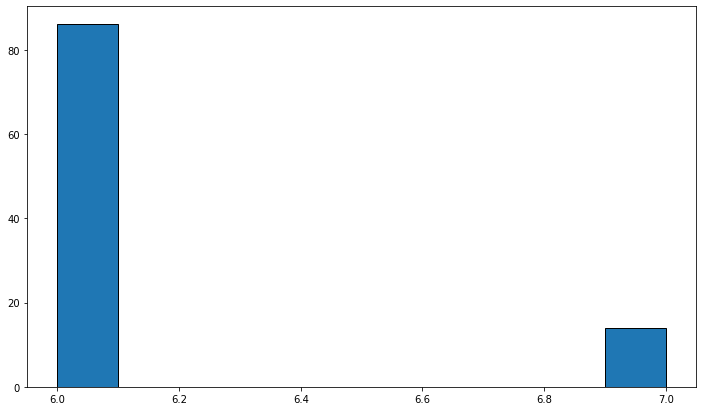

In [19]:
plt.figure(figsize=(12, 7))
plt.hist(n_cars, ec='black')
plt.show()

In [26]:
import heapq


def create_tree_from_edges(edges):
    tree = {}
    for i, j in edges:
        if i != j:
            if i not in tree:
                tree[i] = [j]
            else:
                tree[i].append(j)

            if j not in tree:
                tree[j] = [i]
            else:
                tree[j].append(i)

    tree = {k: list(set(v)) for k, v in tree.items()}

    return tree


def create_spanning_tree(graph, starting_vertex):
    mst = []
    visited = set([starting_vertex])
    edges = [(graph[starting_vertex][to], starting_vertex, to) for to in range(len(graph))]
    heapq.heapify(edges)

    while edges:
        cost, frm, to = heapq.heappop(edges)
        if to not in visited:
            visited.add(to)
            mst.append((frm, to))
            for to_next in range(len(graph)):
                cost = graph[to][to_next]
                if to_next not in visited:
                    heapq.heappush(edges, (cost, to, to_next))

    mst = np.array(mst)
    return mst

In [29]:
def dfs(i, tree, visited, points):
    visited[i] = 1
    for j in tree[i]:
        if j not in visited:
            dfs(j, tree, visited, points)
            points.append((i, j))

In [41]:
all_edges = create_spanning_tree(time_matrix, 0)
clusters = STPClustering(max_length=540).fit_predict(time_matrix)

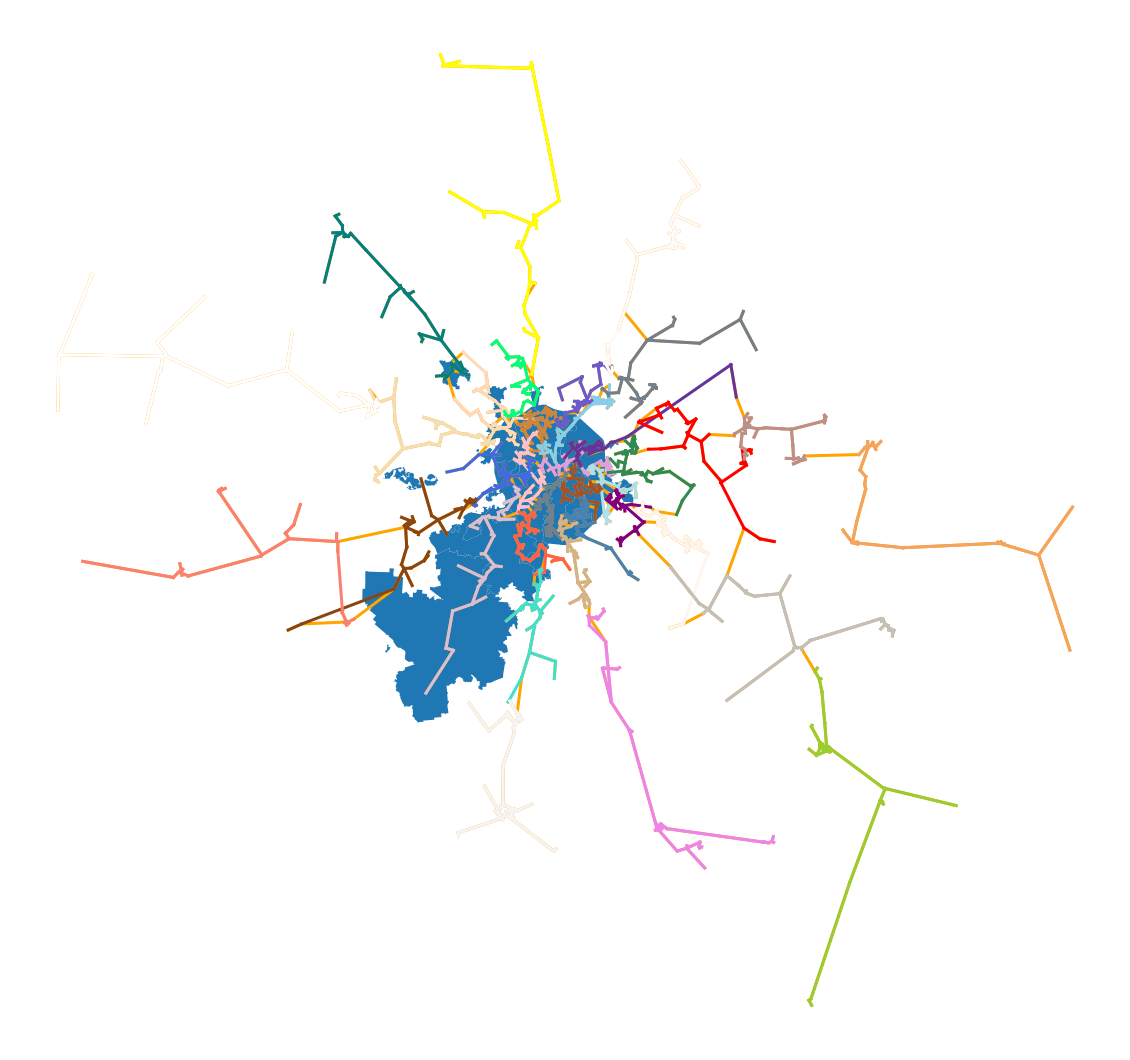

In [49]:
from IPython.display import clear_output


colors = list(mcolors.CSS4_COLORS)[-len(clusters):]
moscow = gpd.read_file('ao-shape.zip')

fig, ax = plt.subplots(figsize=(20, 20))
moscow.plot(ax=ax)

plt.axis('off')
for route in all_edges:
    plt.plot(terminals['longitude'].iloc[route], terminals['latitude'].iloc[route], c='orange', lw=3)

j = 0
for color, cluster in zip(colors, clusters):
    edges = create_spanning_tree(time_matrix[np.ix_(cluster, cluster)], 0)
    edges = np.array([(cluster[i], cluster[j]) for i, j in edges])

    tree = create_tree_from_edges(edges)
    start_point = list(tree.keys())[0]

    edges = []
    dfs(start_point, tree, {}, edges)
    edges = np.array(edges)

    for route in edges:
        plt.plot(terminals['longitude'].iloc[route], terminals['latitude'].iloc[route], c=color, lw=3)
        plt.savefig(f'./assets/clustering_{j}.png', transparent=True)
        j += 1

plt.show()

In [57]:
import glob
import imageio


def create_gif():
    with imageio.get_writer('./assets/routes.gif', mode='I') as writer:
        idx = np.arange(0, 1595, 20)
        filenames = [f'./assets/clustering_{i}.png' for i in idx]
        for filename in tqdm(filenames):
            image = imageio.imread(filename)
            writer.append_data(image)


create_gif()

  0%|          | 0/80 [00:00<?, ?it/s]

In [9]:
idx = np.arange(0, 1595, 40 * 4)
filenames = [f'./assets/clustering_{i}.png' for i in idx]
frames = [plt.imread(filename) for filename in filenames]
for i, frame in enumerate(frames):
    plt.imsave(f'./assets2/image_{i}.png', frame)
# imageio.v3.imwrite('transparent.gif', frames, mode='RGBA', duration=40, loop=0, transparency=0, disposal=2)

In [19]:
import networkx as nx
tsp = nx.approximation.traveling_salesman_problem


def tsp_solution(distances):
    sym_distances = np.maximum(np.tril(distances), np.triu(distances).T)
    sym_distances = sym_distances + sym_distances.T
    G = nx.from_numpy_array(sym_distances)

    if sym_distances.shape[0] > 1:
        path = tsp(G, cycle=False)
    else:
        path = [0]
        
    return path


paths = []
times = []
for cluster in clusters:

    subset = time_matrix[np.ix_(cluster, cluster)]
    # for i in range(len(subset)):
    #     for j in range(len(subset)):
    #         subset[i, j] = min(subset[i, j], np.min(subset[i, :] + subset[:, j]))
    
    path = tsp_solution(subset)
    src, dst = path[:-1], path[1:]
    elapsed = (subset[src, dst]).sum() + 10 * len(path)
    # assert len(np.unique(path)) == len(path)

    paths.append(cluster[path])
    times.append(elapsed)

times = np.array(times)
times.max()

719.05

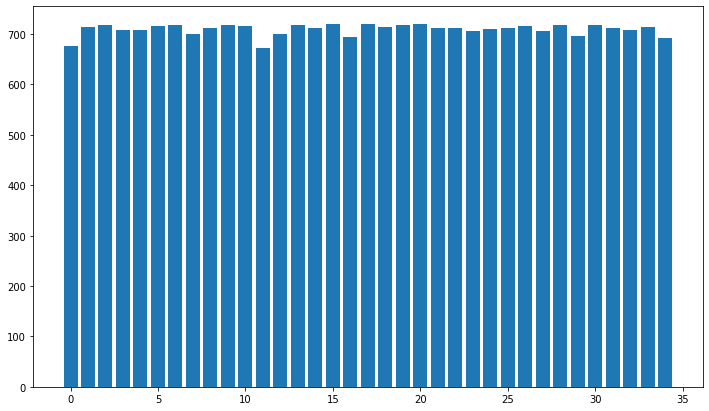

In [20]:
plt.figure(figsize=(12, 7))
plt.bar(np.arange(len(times)), times)
plt.show()

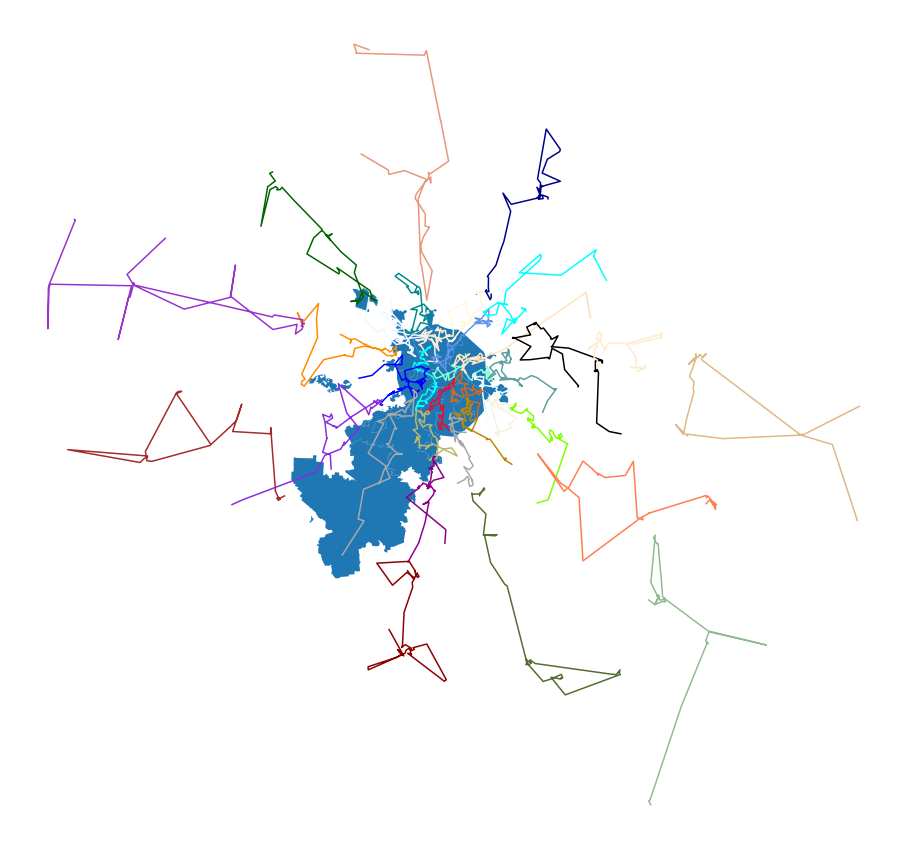

In [22]:
import matplotlib.colors as mcolors


colors = list(mcolors.CSS4_COLORS)
moscow = gpd.read_file('ao-shape.zip')

fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)

for path, color in zip(paths, colors):
    ax.plot(terminals['longitude'].iloc[path], terminals['latitude'].iloc[path], c=color)

plt.axis('off')
# plt.title('Терминалы на карте')
plt.show()